In [76]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

# SERVOMECANISMO SEM INTEGRADOR

In [77]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=4):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

In [78]:
s = ctl.TransferFunction.s

G     = 1/(s*(s+1)*(s+2))
G_bkp = G
G

TransferFunction(array([1]), array([1, 3, 2, 0]))

polos:  (-2+0j) (-1+0j) 0j
zeros: 


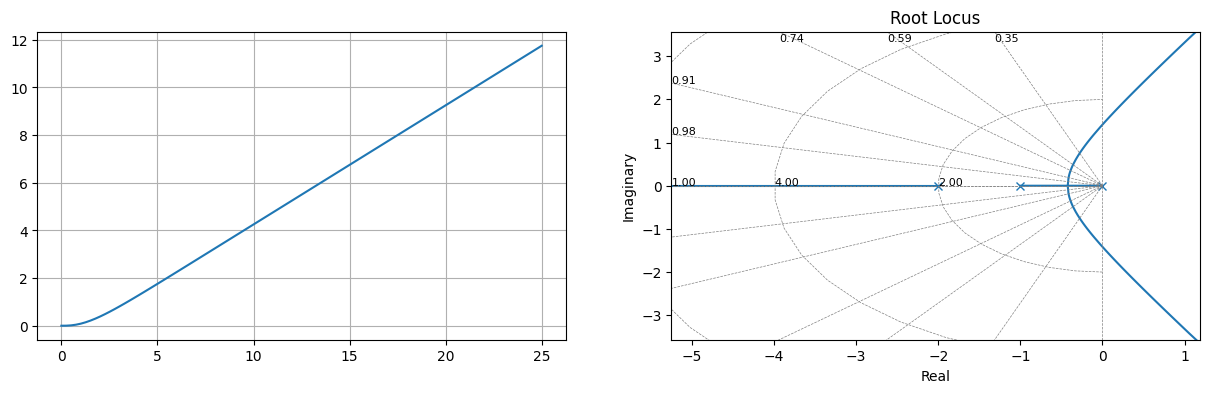

In [79]:
poles = ctl.poles(G)
zeros = ctl.zeros(G)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

time, response = ctl.step_response(G)
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G)
plt.show()

# REQUISITOS DE CONTROLE

(0.4559498107691261, 4.386447702711552, -2.0 + 3.904*I)

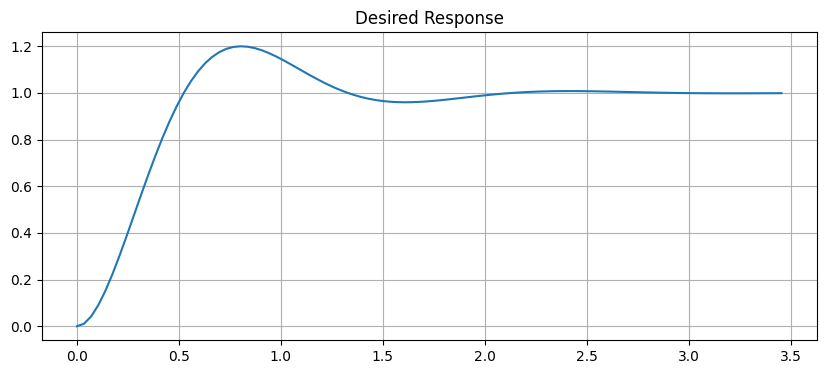

In [80]:
Ts = 2.0
UP = 0.2

zeta = -np.log(UP)/np.sqrt(np.pi**2 + np.log(UP)**2)
Wn = 4/(zeta*Ts)

s_d = -zeta*Wn + Wn*np.sqrt(1-zeta**2)*sp.I
s_d = roundSympyFunction(s_d, 3)
G_desired = Wn**2/(s**2 + 2*zeta*Wn*s + Wn**2)

time, response = ctl.step_response(G_desired)
plt.figure(figsize=(10, 4))
plt.plot(time, response)
plt.title('Desired Response'), plt.grid()
(zeta, Wn, s_d)

In [81]:
s1 = -zeta*Wn + Wn*np.sqrt(1-zeta**2)*1j
s2 = -zeta*Wn - Wn*np.sqrt(1-zeta**2)*1j
s3 = -10                                    # 2 a 5 vezes mais distante dos polos dominantes (parte real)
s4 = -10                                    # 2 a 5 vezes mais distante dos polos dominantes (parte real)


p = [np.round(val, 2) for val in [s1, s2, s3]]
p

[(-2+3.9j), (-2-3.9j), -10]

# ESPAÇO DE ESTADOS
- Forma padrão (computacional)

In [82]:
matrix = ctl.tf2ss(G)
A, B, C, D = matrix.A, matrix.B, matrix.C, matrix.D

display(sp.Matrix(A))
display(sp.Matrix(B))
display(sp.Matrix(C))
display(sp.Matrix(D))

Matrix([
[-3.0, -2.0, 0],
[ 1.0,    0, 0],
[   0,  1.0, 0]])

Matrix([
[1.0],
[  0],
[  0]])

Matrix([[0, 0, 1.0]])

Matrix([[0]])

- Forma variáveis de fase (convencional)

In [83]:
def getVariaveisFase(G):
    matrix = ctl.tf2ss(G)
    A, B, C, D = matrix.A, matrix.B, matrix.C, matrix.D
    
    n = A.shape[0]

    # Cria uma matriz P com elementos 1 na diagonal secundária
    P = np.fliplr(np.eye(n))

    # Calcula a inversa da matriz P
    P_inv = np.linalg.inv(P)

    # Realiza as operações para obter a forma de variáveis de fase
    A = P_inv @ A @ P
    B = P_inv @ B
    C = C @ P
    D = D
    
    return A, B, C, D

A, B, C, D = getVariaveisFase(G)
display(sp.Matrix(A))
display(sp.Matrix(B))
display(sp.Matrix(C))
display(sp.Matrix(D))

Matrix([
[0,  1.0,    0],
[0,    0,  1.0],
[0, -2.0, -3.0]])

Matrix([
[  0],
[  0],
[1.0]])

Matrix([[1.0, 0, 0]])

Matrix([[0]])

In [84]:
n = sp.shape(A)[0]
n

3

# CONTROLADOR
- Encontrando o vetor de ganhos K e também o vetor L para projetar o controlador

In [85]:
K = ctl.acker(A, B, p)
#K = ctl.place(A, B, p)

sp.Matrix(K)

Matrix([[192.1, 57.21, 11.0]])

In [86]:
K1 = K[0][0]
K1

192.10000000000002

In [87]:
L = ctl.acker(A.T, C.T, p).T
#L = ctl.place(A.T, C.T, p).T

sp.Matrix(L)

Matrix([
[ 11.0],
[24.21],
[97.47]])

In [88]:
s = sp.symbols('s')
I = sp.eye(n) 
K = sp.Matrix(K)
L = sp.Matrix(L)
A, B, C, D = sp.Matrix(A), sp.Matrix(B), sp.Matrix(C), sp.Matrix(D)

In [89]:
A_new = A - B*K
B_new = B*K1

display(A_new)
display(B_new)

Matrix([
[     0,    1.0,     0],
[     0,      0,   1.0],
[-192.1, -59.21, -14.0]])

Matrix([
[    0],
[    0],
[192.1]])

- Obtendo toda a função de transferência: $T_F = \frac{Y(s)}{U(s)} = C(sI - A)^{-1}B + D$

In [90]:
T = C * (s*I - A_new).inv() * B_new + D
T = T[0]
T

36902.41/(192.1*s**3 + 2689.4*s**2 + 11374.241*s + 36902.41)

In [91]:
G = sympyFunction(G)
G

1/(s**3 + 3*s**2 + 2*s)

- O controlador C é obtido usando a relação $T(s) = \frac{G(s)C(s)}{1 + C(s)C(s)}$

In [92]:
C = T/(G*(1 - T))
C = C.expand().simplify().factor().cancel()
C = roundSympyFunction(C)
C

(0.0169*s**5 + 0.2871*s**4 + 1.7431*s**3 + 6.7173*s**2 + 11.7332*s + 6.4888)/(0.0001*s**5 + 0.0025*s**4 + 0.0276*s**3 + 0.1626*s**2 + 0.5447*s + 1.0)

# RESPOSTA CONTROLADA

In [93]:
s = ctl.TransferFunction.s
C = eval(str(C))
G = G_bkp

In [94]:
G_ma = G*C
G_ma

TransferFunction(array([ 0.0169,  0.2871,  1.7431,  6.7173, 11.7332,  6.4888]), array([1.0000e-04, 2.8000e-03, 3.5300e-02, 2.5040e-01, 1.0877e+00,
       2.9593e+00, 4.0894e+00, 2.0000e+00, 0.0000e+00]))

In [95]:
G_feedback = ctl.feedback(G_ma, 1)
G_feedback

TransferFunction(array([ 0.0169,  0.2871,  1.7431,  6.7173, 11.7332,  6.4888]), array([1.00000e-04, 2.80000e-03, 3.53000e-02, 2.67300e-01, 1.37480e+00,
       4.70240e+00, 1.08067e+01, 1.37332e+01, 6.48880e+00]))

- Como todos os polos do sistema em malha fechada estão no semiplano esquerdo, o sistema é estável

polos:  (-8.392+3.135j) (-8.392-3.135j) (-2.313+4.456j) (-2.313-4.456j) (-1.795+3.579j) (-1.795-3.579j) (-2+0j) (-1+0j)
zeros:  (-9.987+0j) (-2+3.901j) (-2-3.901j) (-2+0j) (-1+0j)


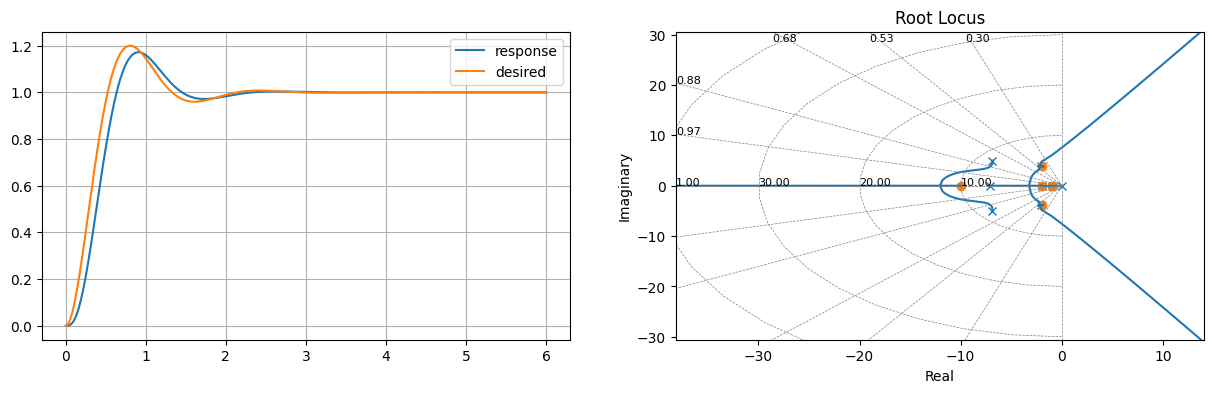

In [96]:
poles = ctl.poles(G_feedback)
zeros = ctl.zeros(G_feedback)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

tData = np.linspace(0, 3*Ts, 1000)
time, response = ctl.step_response(G_feedback, T=tData)
time, desired  = ctl.step_response(G_desired, T=tData)

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(time, response, label='response')
plt.plot(time, desired, label='desired')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
ctl.root_locus(G_ma)
plt.show()

In [97]:
def getOvershoot(time, response):
    peak_value = np.max(response)
    steady_state_value = response[-1]
    overshoot = (peak_value - steady_state_value) / steady_state_value
    return 'inf' if overshoot < 0 or overshoot > 999 else overshoot

def getZeta(overshoot):
    return -np.log(overshoot) / np.sqrt((np.pi**2 + np.log(overshoot)**2))

def getPeakTime(time, response):
    return time[response == max(response)][0] #time[np.argmax(response)]

def getError(response, setpoint=1):
    return abs(setpoint - abs(response[-1]))

def getSettlingTime(time, response, tolerance=0.02):
    steady_state_value = np.mean(response[-50:])
    settling_time = None
    
    if abs(steady_state_value) < 1e-6:
        lower_bound = -tolerance
        upper_bound = tolerance
    else:
        upper_bound = steady_state_value * (1 + tolerance)
        lower_bound = steady_state_value * (1 - tolerance)
    
    for i in range(len(time)):
        if lower_bound <= response[i] <= upper_bound:
            if settling_time is None:
                settling_time = time[i]
        else:
            settling_time = None
    
    return settling_time

def getAllInfo(time, response, show=True, setpoint=1):
    info = {
        'overshoot': getOvershoot(time, response),
        'peakValue': max(response),
        'peakTime': getPeakTime(time, response),
        'settlingTime': getSettlingTime(time, response),
        'finalValue': response[-1],
        'error': getError(response, setpoint)
    }

    if not show:
        return info

    print('overshoot: ', info['overshoot'])
    print('valor de pico: ', info['peakValue'])
    print('tempo de pico: ', info['peakTime'])
    print('tempo de assentamento: ', info['settlingTime'])
    print('valor final: ', info['finalValue'])
    print('erro: ', info['error'])


getAllInfo(time, response, setpoint=1)

overshoot:  0.17226643658878876
valor de pico:  1.1722688078855221
tempo de pico:  0.9069069069069069
tempo de assentamento:  1.9459459459459458
valor final:  1.000002022830868
erro:  2.022830867920433e-06


# APLICANDO VÁRIOS STEPS

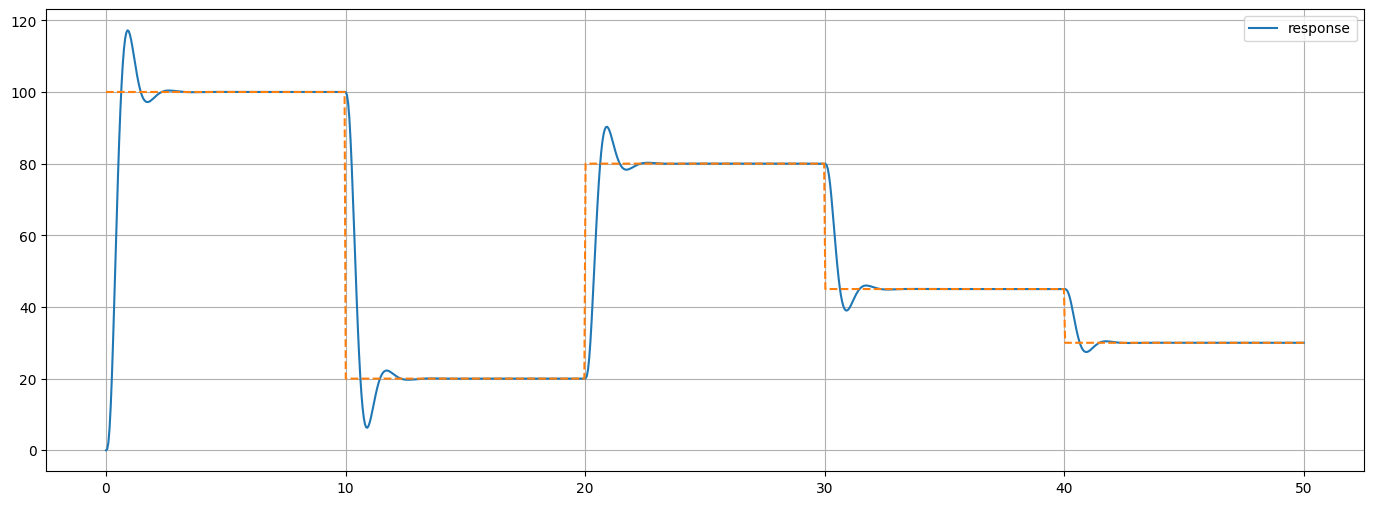

In [98]:
def makeSteps(stepList, length):
    stepSize = length // len(stepList)
    array = []

    for step in stepList:
        array = array + list(step * np.ones(stepSize))

    sizeLeft = len(array) - length

    if sizeLeft > 0:
        array = array + list(stepList[-1] * np.ones(sizeLeft))

    return array


tData = np.linspace(0, 50, 1000)
uData = makeSteps([100, 20, 80, 45, 30], len(tData))

plt.figure(figsize=(17, 6))
time, response = ctl.forced_response(G_feedback, T=tData, U=uData)
plt.plot(time, response, label='response')
plt.plot(time, uData, '--')
plt.legend()
plt.grid()